In [ ]:
#RUN THIS CELL ONLY ONCE
!pip install -r requirements.txt

<h1>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</h1>
<p>This notebook enables to replicate the methods described in: Giovanelli, R.,Traviglia, A., 2023. <i>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</i>.</p>
Run the below cell once to install the needed libraries.

<h2>Web Harvesting</h2>

In [ ]:
#import the libraries that will be used
import spacy
from datetime import datetime
import os
import json
from src.utils.utils import *
from src.db.db_connection import *
from setup import config
import logging
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from html import unescape
from typing import Dict, Any
import hashlib
from event_extraction import *
from kg_construction import *
ner_model = spacy.load("en_core_web_md")
now = datetime.now()
date_and_hour = datetime.now().strftime("%d%m%Y_%H%M")
nlp = spacy.load('en_core_web_md') #load the spacy library for Named Entity Recognition

<h3>Christie's WA</h3>
In the input, insert the first year from wich to start the collection, and the last year. Before 1998 there are no data.</br>
Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</br>
The estimated time for storing data of a sale with around 80 objects and no images is 59 sec on a CPU.</br></p>

In [ ]:
start_year = int(input("Please, input the year from which to start scraping"))
end_year = int(input("Please, input the last year from which you want to scrape")) + 1
storingImage_christies = input("Do you want to store images? Y or N").lower()
if storingImage_christies == 'y':
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=True)
else:
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=False)

In [ ]:
antiquities[0] #run this cell if you want to have a look on the structure of the data

<h3>Sotheby's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>


In [ ]:
with open('auctionIds_sotheby.json','r',encoding='utf-8') as file:
    auctionIds_sotheby = json.load(file)

storingImage_sothebys = input("Do you want to store images? Y or N").lower()
if storingImage_sothebys == 'y':
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=True)
else:
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=False)

In [ ]:
antiquities_sothebys[0] #run this cell if you want to have a look on the structure of the data

<h3>Phoenix Ancient Art's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>

In [ ]:
storingImage_paa = input("Do you want to store images? Y or N").lower()
if storingImage_paa == 'y':
    antiquities_paa = collectPAA(storeImage=True)
else:
    antiquities_paa = collectPAA(storeImage=False)

In [ ]:
antiquities_paa[0] #run this cell if you want to have a look on the structure of the data

<h2>Ontology mapping and Knowledge Graph database building</h2>

<h3>Ontology mapping</h3>
<p>The following cell will reload the datasets you stored from the previous cells and remap the datasets toward a single cleaned and postprocessed datasets, with only the relevant key-values pairs and a common taxonomy</p>

In [ ]:
import json
with open(r'christies_raw.json','r',encoding='utf-8') as f:
    christies_data = json.load(f)
with open(r'sothebys_raw.json','r',encoding='utf-8') as f2:
    sothebys_data = json.load(f2)
with open(r'paa_raw.json','r',encoding='utf-8') as f3:
    paa_data = json.load(f3)

# Set up logging
logging.basicConfig(filename='error_log.log', level=logging.ERROR,format='%(asctime)s - %(levelname)s - %(message)s')
# Map Christie's data to the final keys
final_christies_data = remap_christies_data(christies_data)
# Map Sotheby's data to the final keys
final_sothebys_data = map_sothebys_data(sothebys_data)
# Map PAA's data to the final keys
final_paa_data = remap_paa_data(paa_data)
# Combine datasets into a single list
final_output = final_sothebys_data + final_christies_data + final_paa_data
# Hash and Reorder json file
db = hashAndClean(final_output)

The following cell will save in a .json file inside datasets folder the complete data

In [ ]:
with open(r'datasets/db.json','w') as file:
  json.dump(db,file)

The following cell will reload the completa data file

<h3>Knowledge Graph database building</h3>
The following cells will generate a Neo4j Knowledge Graph from the .json dataset, extracting events from the provenance statements as collected and refactoring them into separate entities such as actors, dates, locations.</br>
Before running the following cells make sure to follow the Neo4j installation guidelines.</br>
<p>
<b>Neo4j Installation and setup</b></br>
Install Neo4J Desktop from <a href='https://neo4j.com/deployment-center/'> here </a> chosing the right os.</br>
<img src="imgs/n4jdsk.png" width='630'> </br>
Follow along the guide from Neo4j documentation <a href='https://neo4j.com/docs/desktop-manual/current/'>here</a>.</br>
When you first database is created, as described <a href='https://neo4j.com/docs/desktop-manual/current/operations/create-dbms/'>here</a>, you will need to adjust the configuration inside the <a href='setup/config.py'>config.py</a> file under 'setup' folder in this project, changing the uri and the password according to your Neo4j Desktop configurations. The default localhost and username are the following, the password is set by you upon creating your first database instance.
```
neo4j = {
    "uri":"bolt://localhost:7687",
    "username": "neo4j",
    "password": "admininstrator",
    "encrypted": False
}
```
</p>
<p>When both Neo4j Desktop and the config file are set, click "Start" to start the Neo4j Database instance and then "Open".</p>
<p><img src='imgs/kgopen.png' width='630'></p>
<p></p>
<p><img src='imgs/kgstart.png' width='630'></p>
<p>This will open in a new window an empty database.</br>
<img src='imgs/newdb.png' width = '630'></br>
Making sure our database is <b>active</b>, we can procede and run the following cells.</p>

The following event_extraction.py analyses and splits each provenance statement found in the raw data into different <i>events</i>. Each event ideally contains an actor, a location, and a time-span indication.
For testing, we utilise the NER model 'en-core-web-md' from Spacy library. The output 'events/events.txt' will contain for each artwork the labeled entities found in each separated provenance event. </br>
The estimated time for extracting events from 39103 objects is 64 minutes on a CPU (nearly 10 objects/s)</br>

In [ ]:
from event_extraction import *
if __name__ == "__main__":
    
    # Named Entity Recognition (NER) model
    ner_model = spacy.load("en_core_web_md")
    
    file = 'datasets/db.json'

    artwork_index = 0
    artwork_index = extract_store_events(ner_model, file, artwork_index)
    
        
    print("Job done")        
      

In [ ]:
json_line = json.loads(lines[0])

The following code will populate the Neo4j database with the original nodes of artworks and events connected to the corresponding artworks through a (a:artwork)-[r:PARTICIPATED_TO_EVENT]->(b:event) relationship.</br>
In this way, each event involving a specific object is automatically linked to the respective entities represented within it.</br>
Autonomous CYPHER queries refactor the events according to the ontology schema: the event node remains central, receiving relationships from the artworks and projecting or receiving new relationships to other entities automatically generated by Spacy and refactored based on our ontology.</br>
The estimated time for building and refactoring the Neo4j KG Database is  minutes on a CPU.</br>

In [ ]:
import kg_construction
from kg_construction import *
if __name__ == "__main__":
    main()

<h2>Preliminary Results</h2>

In [1]:
def generalQuery(query):
    from neo4j import GraphDatabase
    driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "administrator"), encrypted=False)
    tx = driver.session().begin_transaction()
    result = tx.run(query)
    records = []
    for record in result:
        records.append(record)

    
    print(query)
    return records

In [2]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import pickle
import os
from tqdm.notebook import tqdm

<h3>First Projection: from Knowledge Graph to bipartite Graph</h3>

With the following cell we connect to our Neo4j database and collect artwor, events and actors nodes with their relationsip.

In [3]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import pickle
import os
from tqdm.notebook import tqdm
import pickle
from unidecode import unidecode


query = "MATCH (n:artwork)-[r]-(e:event)-[r2]-(a:actor) RETURN *"
result = generalQuery(query)

G = nx.Graph()

for record in tqdm(result):
    artwork_node = record["n"]
    event_node = record["e"]
    actor_node = record["a"]
    relationship_1 = record["r"]
    relationship_2 = record["r2"]

    # Add nodes and edges to the NetworkX graph
    G.add_node(artwork_node.id, label='artwork', properties=artwork_node._properties)    
    G.add_node(event_node.id, label="event", properties=event_node._properties)
    G.add_node(actor_node.id, label="actor", properties=actor_node._properties)
    G.add_edge(artwork_node.id, event_node.id, label=relationship_1.type, direction='forward')
    G.add_edge(event_node.id, actor_node.id, label=relationship_2.type, direction='reverse')

print("Node count:", G.number_of_nodes())
print("Edge count:", G.number_of_edges())

os.makedirs('graphs', exist_ok=True)
# save graph object to file
pickle.dump(G, open('graphs/graph.pickle', 'wb'))

MATCH (n:artwork)-[r]-(e:event)-[r2]-(a:actor) RETURN *


  0%|          | 0/111388 [00:00<?, ?it/s]

Exception ignored in: <function Session.__del__ at 0x000001F5CD64A280>
Traceback (most recent call last):
  File "C:\Users\rgiovanelli.IIT\PycharmProjects\nlp\env\lib\site-packages\neo4j\work\simple.py", line 95, in __del__
    self.close()
  File "C:\Users\rgiovanelli.IIT\PycharmProjects\nlp\env\lib\site-packages\neo4j\work\simple.py", line 149, in close
    self._transaction.rollback()  # roll back the transaction if it is not closed
  File "C:\Users\rgiovanelli.IIT\PycharmProjects\nlp\env\lib\site-packages\neo4j\work\transaction.py", line 156, in rollback
    self._connection.send_all()
  File "C:\Users\rgiovanelli.IIT\PycharmProjects\nlp\env\lib\site-packages\neo4j\io\_bolt4.py", line 296, in send_all
    raise ServiceUnavailable("Failed to write to closed connection {!r} ({!r})".format(
neo4j.exceptions.ServiceUnavailable: Failed to write to closed connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687)))


Node count: 114682
Edge count: 168363


In [3]:
# load graph object from file
G = pickle.load(open('graphs/graph.pickle', 'rb'))

In [4]:
def refactoring(string, graph):
    old_actors_nodes = set()
    
    # Identify actor nodes with 'Sotheby's' in their name
    for node in tqdm(subgraph.nodes(), desc=f"Identifying {string.capitalize()} nodes"):
        if graph.nodes[node]['label'] == 'actor':
            name = graph.nodes[node]['properties']['name']
            if string in name.lower():
                old_actors_nodes.add(node)
    
    # Create the super node and update relationships
    # Update relationships for super node
    if old_actors_nodes:
        for actor in tqdm(old_actors_nodes, desc=f'Updating relationships for {string.capitalize()}'):
            neighbors = list(graph.neighbors(actor))
            for neighbor in neighbors:
                edges = graph.edges(actor, neighbor)
                for edge in edges:
                    graph.add_edge(string.capitalize(), neighbor, attr_dict=edge[2])
        
        graph.add_edges_from(edges_to_add)
        graph.remove_nodes_from(nodes_to_remove)

    return graph

def newNodeId(subgraph):
    all_ids = {node for node in subgraph.nodes() if isinstance(node, int)}
    new_node_id = str(min(set(range(1, max(all_ids) + 2)) - all_ids))
    return new_node_id

from unidecode import unidecode

def normalize_name(name):
    return unidecode(name.lower())

def merge_nodes_with_name(graph, name):
    normalized_name = normalize_name(name)
    nodes_to_merge = [node for node in graph.nodes() if graph.nodes[node]['label'] == 'actor' and normalized_name in normalize_name(graph.nodes[node]['properties']['name']) and node != name]
    
    if nodes_to_merge:
        merged_node_id = name
        graph.add_node(merged_node_id, label='actor', properties={'name': merged_node_id})
        
        for node in nodes_to_merge:
            neighbors = list(graph.neighbors(node))
            for neighbor in neighbors:
                if graph.nodes[neighbor]['label'] == 'artwork':
                    graph.add_edge(merged_node_id, neighbor, label='dealt_with', direction='forward')
            graph.remove_node(node)

    
    
    return graph

def normalize_name(name):
    """
    Normalize a name by converting it to lowercase and removing Unicode characters.
    
    Parameters:
    name (str): The input name to be normalized.
    
    Returns:
    str: The normalized name.
    """
    return unidecode(name.lower())

def generate_ngrams(string, n):
    """
    Generate n-grams of length n from a given string.
    
    Parameters:
    string (str): The input string from which n-grams will be generated.
    n (int): The length of each n-gram.
    
    Returns:
    list: A list of n-grams.
    """
    return [string[i:i + n] for i in range(len(string) - n + 1)]

def build_ngram_index(strings, n=3):
    """
    Build an n-gram index for a list of strings.
    Each n-gram maps to a list of strings containing that n-gram.
    
    Parameters:
    strings (list): List of strings to build the n-gram index from.
    n (int): The length of each n-gram.
    
    Returns:
    defaultdict: A defaultdict containing the n-gram index.
    """
    ngram_index = defaultdict(list)
    for string in strings:
        ngrams = generate_ngrams(string, n)
        for ngram in ngrams:
            ngram_index[ngram].append(string)
    return ngram_index

def exception_append(shorter_string, merges, ngram_index):
    """
    Append a string to the list of merges if it doesn't meet any exception criteria.
    Also, check if the string's n-grams match with any existing strings using the n-gram index.
    
    Parameters:
    shorter_string (str): The string to be added to the merges list.
    merges (list): The list of merged strings.
    ngram_index (defaultdict): The n-gram index built from build_ngram_index function.
    
    Returns:
    list: The updated merges list.
    """
    if shorter_string in merges or shorter_string.lower() in exceptionsin or shorter_string.lower() in exceptionsequals:
        return merges
    # Check if any of the n-grams of the new string are present in the n-gram index
    ngrams = generate_ngrams(shorter_string, 3)  # Using 3-grams for comparison
    for ngram in ngrams:
        if ngram in ngram_index:
            print(f"Similarity found for '{shorter_string}': {ngram_index[ngram]}")
            break
    merges.append(shorter_string)
    print(f"Added to merges: {shorter_string}")
    return merges

def find_similar_nodes(graph, merges, threshold=0.8):
    """
    Find nodes with similar names in the graph and update the list of merges accordingly.
    Also, utilize the n-gram index to identify similar strings.
    
    Parameters:
    graph (NetworkX Graph): The graph containing nodes to compare.
    merges (list): The list of merged strings.
    threshold (float, optional): The similarity threshold for node comparison.
    
    Returns:
    tuple: A tuple containing the list of similar nodes and the updated merges list.
    """
    similar_nodes = []
    ngram_index = build_ngram_index(merges)

    for node1 in tqdm(graph.nodes(), desc='Calculating similarity'):
        if graph.nodes[node1]['label'] == 'actor':
            name1 = graph.nodes[node1]['properties']['name']
            normalized_name1 = normalize_name(name1)

            for node2 in graph.nodes():
                if node1 != node2 and graph.nodes[node2]['label'] == 'actor':
                    name2 = graph.nodes[node2]['properties']['name']
                    normalized_name2 = normalize_name(name2)
                    

                    if normalized_name2 == normalized_name1:
                        shorter_string = normalized_name1 if len(normalized_name1) < len(normalized_name2) else normalized_name2
                        shorter_string = shorter_string.title()
                        merges = exception_append(shorter_string, merges, ngram_index)
                    else:
                        similarity = fuzz.ratio(normalized_name1, normalized_name2) / 100
                        if similarity >= threshold:
                            similar_nodes.append((node1, node2, similarity))
                            similarity = round(similarity, 2)
                            if similarity == 1.00:
                                shorter_string = normalized_name1 if len(normalized_name1) < len(normalized_name2) else normalized_name2
                                shorter_string = shorter_string.title()
                                merges = exception_append(shorter_string, merges, ngram_index)

    return similar_nodes, merges

def delete_nodes_by_name(graph, target_name):
    nodes_to_delete = [node for node in graph.nodes() if graph.nodes[node]['label'] == 'actor' and graph.nodes[node]['properties']['name'] == target_name]
    for node in nodes_to_delete:
        graph.remove_node(node)
    print("Node count:", graph.number_of_nodes())
    print("Edge count:", graph.number_of_edges())
    return graph

Once we collected the nodes that we need to perform the refactoring, we actually refactor our graph transforming each event to which both an artwork and a actor participated into a directed relationship (actor)-[:DEALT_WITH]->(artwork).  

In [5]:
# Create a copy of the original graph
subgraph = G.copy()

# List to store nodes to be removed
nodes_to_remove = []

# Identify and remove event nodes
for node in tqdm(list(subgraph.nodes()), desc='Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors'):
    if subgraph.nodes[node]['label'] == 'event':
        # Find connected actor and artwork nodes
        neighbors = list(subgraph.neighbors(node))
        actor_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'actor']
        artwork_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'artwork']
        
        # Add the actor-artwork relationships
        for actor in actor_nodes:
            for artwork in artwork_nodes:
                subgraph.add_edge(actor, artwork, label='dealt_with', direction='forward')
        
        # Add the event node to nodes_to_remove list
        nodes_to_remove.append(node)

# Remove the nodes
subgraph.remove_nodes_from(nodes_to_remove)

print("Node count:", subgraph.number_of_nodes())
print("Edge count:", subgraph.number_of_edges())

# Set titles for remaining nodes
for node in tqdm(subgraph.nodes(), desc='Setting titles'):
    if subgraph.nodes[node]['label'] == 'actor':
        name = subgraph.nodes[node]['properties']['name']
        subgraph.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif subgraph.nodes[node]['label'] == 'artwork':
        lotTitle = subgraph.nodes[node]['properties']['lotTitle']
        subgraph.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
        
# Select a subset of nodes for visualization
subset_nodes = list(subgraph.nodes())[:200]  # Change the number of nodes as needed
subgraph_subset = subgraph.subgraph(subset_nodes)

# Create a Network instance
nt = Network(notebook=True)
nt.from_nx(subgraph_subset)

# Display the interactive visualization
#nt.show('graph_subset.html', notebook=True)

Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors:   0%|          | 0/114682 [00:00<?, ?it/s]

Node count: 53354
Edge count: 98579


Setting titles:   0%|          | 0/53354 [00:00<?, ?it/s]

from fuzzywuzzy import fuzz
from collections import defaultdict
from tqdm.notebook import tqdm
from unidecode import unidecode
merges = ["Sotheby's","Christie's","Junkunc","the Tuyet Nguyet","Koutoulakis","Hotel Drouot","Henry H Arnhold","Alan Steele","Groppi Collection","Empain","Jon Edwards"]
# Set of strings that should be considered exceptions
exceptionsequals = {'house', 'sa', 'collection', 'antiquites', 'archeologie', 'un', 'inc'}
exceptionsin = {'private collection', 'collection privee', 'the estate of the late', 'collection particuliere', 'private european collection', 'property of a new york city collection', 'property from an important american collection','royal'}

# Example usage
similar_nodes, merges = find_similar_nodes(subgraph, merges, threshold=0.8)
for node1, node2, similarity in similar_nodes:
    print(f"Nodes {node1} and {node2} are similar with similarity {similarity:.2f}")

In [7]:
# Refactor nodes for 'Sotheby's' and 'Christie's
subgraph.nodes[114940]['properties']['name'] = subgraph.nodes[114939]['properties']['name']
merges = ["Sotheby's","Christie's","Junkunc","the Tuyet Nguyet","Koutoulakis","Hotel Drouot","Henry H Arnhold","Alan Steele","Groppi Collection","Empain","Jon Edwards"]
for x in merges:
    merge_nodes_with_name(subgraph,x)

print("Node count:", subgraph.number_of_nodes())
print("Edge count:", subgraph.number_of_edges())

Node count: 52884
Edge count: 93411


In [8]:
# Set titles for remaining nodes
for node in tqdm(subgraph.nodes(), desc='Setting titles'):
    if subgraph.nodes[node]['label'] == 'actor':
        name = subgraph.nodes[node]['properties']['name']
        subgraph.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif subgraph.nodes[node]['label'] == 'artwork':
        lotTitle = subgraph.nodes[node]['properties']['lotTitle']
        subgraph.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
        
import random

# Choose a random starting node
starting_node = random.choice(list(subgraph.nodes()))
print(starting_node)

# Perform a breadth-first search to collect connected nodes
def get_connected_nodes(graph, starting_node, num_nodes):
    connected_nodes = set()
    queue = [starting_node]
    
    while queue and len(connected_nodes) < num_nodes:
        current_node = queue.pop(0)
        connected_nodes.add(current_node)
        neighbors = list(graph.neighbors(current_node))
        for neighbor in neighbors:
            if neighbor not in connected_nodes:
                queue.append(neighbor)
    
    return connected_nodes

# Choose a random starting node
starting_node = random.choice(list(subgraph.nodes()))
print(starting_node)

# Choose the number of nodes to visualize
num_nodes_to_visualize = 50

# Get the subset of connected nodes
connected_nodes_subset = get_connected_nodes(subgraph, starting_node, num_nodes_to_visualize)
subgraph_connected_subset = subgraph.subgraph(connected_nodes_subset)

# Create a Network instance
nt_connected = Network(notebook=True)
nt_connected.from_nx(subgraph_connected_subset)

# Display the interactive visualization
#nt_connected.show('graph_connected_subset.html', notebook=True)


Setting titles:   0%|          | 0/52884 [00:00<?, ?it/s]

117487
20382


Sotheby's
Christie's
114264
the Tuyet Nguyet
Junkunc
House
114257
Henry H Arnhold
114258
120668
120667
115325
114882
Koutoulakis
Alan Steele
121571
114240
115264
Hotel Drouot
114778
115650
115498
Ralph M Chait Galleries
115077
Jon Edwards
114766
Collection Of T
114272


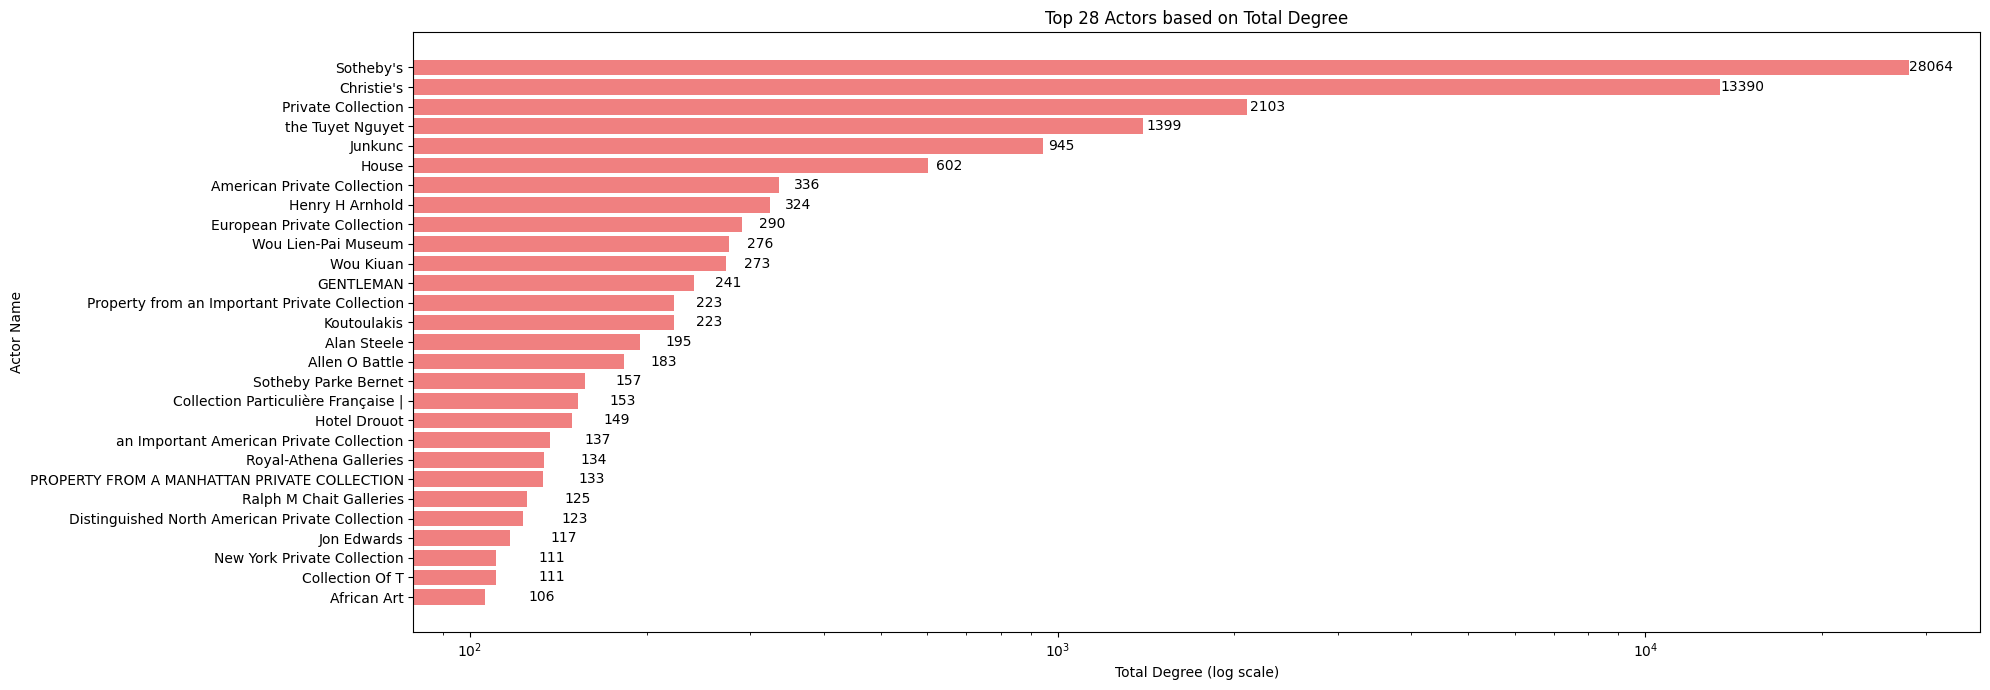

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Calculate total degree for each actor node
actor_degrees = {node: subgraph.degree(node) for node in subgraph.nodes() if subgraph.nodes[node]['label'] == 'actor'}

# Sort nodes by total degree in descending order
sorted_nodes = sorted(actor_degrees, key=actor_degrees.get, reverse=True)

# Choose the top 28 nodes (actors with highest total degree)
top_nodes = sorted_nodes[:28]
for node in top_nodes:
    print(node)
    

# Get names and total degree values for the top nodes
node_names = [subgraph.nodes[node]['properties']['name'] for node in top_nodes]
node_total_degrees = [actor_degrees[node] for node in top_nodes]

# Create a bar plot with logarithmic scale
plt.figure(figsize=(20, 7))  # Adjust the figure size for a 2:1 ratio
bars = plt.barh(node_names, node_total_degrees, color='lightcoral')  # Use a light coral color
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Total Degree (log scale)')
plt.ylabel('Actor Name')
plt.title('Top 28 Actors based on Total Degree')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest degree at the top

# Display total degree values inside the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() +20, bar.get_y() + bar.get_height()/2, f'{node_total_degrees[i]}', va='center')
# Adjust margins to prevent text from going outside the figure boundary
plt.subplots_adjust(left=0.2, right=15)

# Create 'plots' directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

plt.tight_layout()  # Adjust layout for better appearance
plt.savefig('plots/total_degree_plot.png', dpi=300, bbox_inches='tight')  # Save the plot to a file
plt.show()




<h3>Second Projection: from bipartite to a one-mode undirected weighted graph (actors)-[:SHARES_ARTWORK]-(actors)</h3>

The following cell will operate the projection directly in python, but it takes a long time

In [9]:
import networkx as nx
from tqdm.notebook import tqdm
import community


import networkx as nx

# Your graph creation code here
# subgraph = ...

# Create a new directed graph to hold the adjusted edges
adjusted_graph = nx.DiGraph()
# Sort nodes by degree in descending order
sorted_nodes = sorted(subgraph.nodes(), key=lambda x: subgraph.degree(x), reverse=True)

# Create a new undirected subgraph for actor sharing artwork
shared_artwork_subgraph = nx.Graph()

# Create a subgraph excluding the highest degree nodes "Christie's" and "Sotheby's"
subgraph_excluded = subgraph.subgraph(sorted_nodes[2:])
# Iterate through the 'actor' nodes in the original subgraph
for actor in tqdm(subgraph_excluded.nodes(),desc='Processing nodes'):
    if subgraph.nodes[actor]['label'] == 'actor':
        # Get the 'artwork' neighbors of the current 'actor'
        actor_neighbors = [neighbor for neighbor in subgraph_excluded.neighbors(actor) if subgraph_excluded.nodes[neighbor]['label'] == 'artwork']
        # Create edges between the 'actor' and 'artwork' neighbors
        for artwork in actor_neighbors:
            shared_actors = [neighbor for neighbor in subgraph_excluded.neighbors(artwork) if neighbor != actor and subgraph_excluded.nodes[neighbor]['label'] == 'actor']
            for shared_actor in shared_actors:
                # Add the start node as 'actor' and the end node as 'actor' in the adjusted graph
                adjusted_graph.add_node(actor, **subgraph_excluded.nodes[actor])
                adjusted_graph.add_node(shared_actor, **subgraph_excluded.nodes[shared_actor])
                # Add the edge between actors with weight based on the number of shared artworks
                shared_artworks_count = len([neighbor for neighbor in subgraph_excluded.neighbors(artwork) if subgraph_excluded.nodes[neighbor]['label'] == 'actor'])
                adjusted_graph.add_edge(actor, shared_actor, weight=shared_artworks_count)

# Convert the directed graph to an undirected graph
adjusted_graph = adjusted_graph.to_undirected()

# Find all connected components in the undirected graph
connected_components = list(nx.connected_components(adjusted_graph))

# Find the largest connected component
largest_connected_component = max(connected_components, key=len)
print(len(largest_connected_component))

# Create a subgraph containing only the largest connected component
largest_subgraph = adjusted_graph.subgraph(largest_connected_component)
adjusted_graph = largest_subgraph

Processing nodes:   0%|          | 0/52882 [00:00<?, ?it/s]

10092


In [10]:
from py2neo import Graph, Node, Relationship
import networkx as nx
import threading
import time
from tqdm.notebook import tqdm

# Number of Nodes
num_nodes = largest_subgraph.number_of_nodes()
print("Number of Nodes:", num_nodes)

# Number of Relationships (edges)
num_edges = largest_subgraph.number_of_edges()
print("Number of Relationships:", num_edges)

# Average Degree
avg_degree = sum(dict(largest_subgraph.degree()).values()) / num_nodes
print("Average Degree (AD):", avg_degree)


# Create a lock to prevent concurrent access
#lock = threading.Lock()


def calculate_with_timeout(func, graph, timeout):
    result = None

    def calculation_thread():
        nonlocal result
        try:
            result = func(graph)
        except Exception as e:
            result = "Calculation error: " + str(e)

    thread = threading.Thread(target=calculation_thread)
    thread.start()
    thread.join(timeout)
    
    if thread.is_alive():
        thread.join()  # Make sure the thread is terminated
        result = "Calculation took too long and was terminated."

    return result
'''
# Calculate Average Path Length with timeout
avg_path_length = calculate_with_timeout(nx.average_shortest_path_length, largest_subgraph, timeout=20)
print("Average Path Length (L):", avg_path_length)

# Calculate Average Clustering Coefficient with timeout
avg_clustering = calculate_with_timeout(nx.average_clustering, largest_subgraph, timeout=20)
print("Average Clustering Coefficient (C):", avg_clustering)

# Calculate Graph Edge Density with timeout
graph_density = calculate_with_timeout(nx.density, largest_subgraph, timeout=20)
print("Graph Edge Density (Dns):", graph_density)

# Calculate Graph Diameter with timeout
graph_diameter = calculate_with_timeout(nx.diameter, largest_subgraph, timeout=20)
print("Graph Diameter:", graph_diameter)
'''

Number of Nodes: 10092
Number of Relationships: 60179
Average Degree (AD): 11.926080063416567


'\n# Calculate Average Path Length with timeout\navg_path_length = calculate_with_timeout(nx.average_shortest_path_length, largest_subgraph, timeout=20)\nprint("Average Path Length (L):", avg_path_length)\n\n# Calculate Average Clustering Coefficient with timeout\navg_clustering = calculate_with_timeout(nx.average_clustering, largest_subgraph, timeout=20)\nprint("Average Clustering Coefficient (C):", avg_clustering)\n\n# Calculate Graph Edge Density with timeout\ngraph_density = calculate_with_timeout(nx.density, largest_subgraph, timeout=20)\nprint("Graph Edge Density (Dns):", graph_density)\n\n# Calculate Graph Diameter with timeout\ngraph_diameter = calculate_with_timeout(nx.diameter, largest_subgraph, timeout=20)\nprint("Graph Diameter:", graph_diameter)\n'

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Your adjusted_graph
adjusted_graph = largest_subgraph

# Calculate centrality measures
degree_centrality = nx.degree_centrality(adjusted_graph)
betweenness_centrality = nx.betweenness_centrality(adjusted_graph)
closeness_centrality = nx.closeness_centrality(adjusted_graph)
eigenvector_centrality = nx.eigenvector_centrality(adjusted_graph)

# Get centrality values for each node
degree_values = np.array([degree_centrality[node] for node in adjusted_graph.nodes()])
betweenness_values = np.array([betweenness_centrality[node] for node in adjusted_graph.nodes()])
closeness_values = np.array([closeness_centrality[node] for node in adjusted_graph.nodes()])
eigenvector_values = np.array([eigenvector_centrality[node] for node in adjusted_graph.nodes()])

# Create scatter plots
plt.figure(figsize=(12, 10))

# Degree vs Betweenness
plt.subplot(321)
plt.scatter(degree_values, betweenness_values, alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
slope, intercept, r_value, p_value, std_err = linregress(degree_values, betweenness_values)
plt.plot(degree_values, slope * degree_values + intercept, color='red')
plt.title(f"Degree vs Betweenness (R-squared = {r_value ** 2:.2f})")

# Degree vs Closeness
plt.subplot(322)
plt.scatter(degree_values, closeness_values, alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Closeness Centrality")
slope, intercept, r_value, p_value, std_err = linregress(degree_values, closeness_values)
plt.plot(degree_values, slope * degree_values + intercept, color='red')
plt.title(f"Degree vs Closeness (R-squared = {r_value ** 2:.2f})")

# Degree vs Eigenvector
plt.subplot(323)
plt.scatter(degree_values, eigenvector_values, alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Eigenvector Centrality")
slope, intercept, r_value, p_value, std_err = linregress(degree_values, eigenvector_values)
plt.plot(degree_values, slope * degree_values + intercept, color='red')
plt.title(f"Degree vs Eigenvector (R-squared = {r_value ** 2:.2f})")

# Betweenness vs Closeness
plt.subplot(324)
plt.scatter(betweenness_values, closeness_values, alpha=0.5)
plt.xlabel("Betweenness Centrality")
plt.ylabel("Closeness Centrality")
slope, intercept, r_value, p_value, std_err = linregress(betweenness_values, closeness_values)
plt.plot(betweenness_values, slope * betweenness_values + intercept, color='red')
plt.title(f"Betweenness vs Closeness (R-squared = {r_value ** 2:.2f})")

# Betweenness vs Eigenvector
plt.subplot(325)
plt.scatter(betweenness_values, eigenvector_values, alpha=0.5)
plt.xlabel("Betweenness Centrality")
plt.ylabel("Eigenvector Centrality")
slope, intercept, r_value, p_value, std_err = linregress(betweenness_values, eigenvector_values)
plt.plot(betweenness_values, slope * betweenness_values + intercept, color='red')
plt.title(f"Betweenness vs Eigenvector (R-squared = {r_value ** 2:.2f})")

# Closeness vs Eigenvector
plt.subplot(326)
plt.scatter(closeness_values, eigenvector_values, alpha=0.5)
plt.xlabel("Closeness Centrality")
plt.ylabel("Eigenvector Centrality")
slope, intercept, r_value, p_value, std_err = linregress(closeness_values, eigenvector_values)
plt.plot(closeness_values, slope * closeness_values + intercept, color='red')
plt.title(f"Closeness vs Eigenvector (R-squared = {r_value ** 2:.2f})")

plt.tight_layout()
plt.show()


{114214: 0.0004954910316123278, 120519: 9.909820632246556e-05, 'Spink & Son Ltd': 0.004558517490833415, 120520: 9.909820632246556e-05, 114218: 0.003963928252898622, 'Bluett & Sons': 0.008324249331087108, 114341: 0.001981964126449311, 114342: 0.00267565157070657, 117375: 0.005153106728768209, 117385: 0.0005945892379347934, 124901: 0.004756713903478347, 124902: 0.004756713903478347, 124897: 0.0011891784758695867, 124898: 0.0011891784758695867, 114264: 0.11852145476166881, 115713: 0.0005945892379347934, 122394: 0.0005945892379347934, 122395: 0.0005945892379347934, 'The Meiyintang Collection': 0.0018828659201268457, 'Eskenazi Ltd': 0.00802695471211971, 115537: 0.0011891784758695867, 115538: 0.0005945892379347934, 122107: 0.0004954910316123278, 122108: 0.0006936874442572589, 122109: 0.0005945892379347934, 114957: 0.0004954910316123278, 121390: 0.00039639282528986224, 121391: 0.00039639282528986224, 121392: 0.0013873748885145178, 114755: 0.0004954910316123278, 'Junkunc': 0.002279258745416707